## Bonus - Classification

In [2]:
import pandas
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, plot_confusion_matrix, plot_roc_curve
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE

In [3]:
# Load data
data = pandas.read_table("./dataset_lab3/dataset_10/capture20110818.binetflow", sep=",")

# Remove background flows
data = data[~data.Label.str.contains("Background")].reset_index()
data = data.drop(columns='index')

data.head()

,StartTime,Dur,Proto,SrcAddr,Sport,Dir,DstAddr,Dport,State,sTos,dTos,TotPkts,TotBytes,SrcBytes,Label
0,2011/08/18 10:19:15.693956,3587.569824,tcp,147.32.84.164,54784,<?>,74.125.232.215,443,PA_PA,0.0,0.0,3049,978731,245317,flow=From-Normal-V51-Grill
1,2011/08/18 10:19:18.143576,198.072739,tcp,147.32.84.164,56165,<?>,74.125.232.197,80,FA_FA,0.0,0.0,14,924,462,flow=From-Normal-V51-Grill
2,2011/08/18 10:19:18.303590,197.928329,tcp,147.32.84.164,57965,<?>,209.85.149.138,80,FA_FA,0.0,0.0,14,924,462,flow=From-Normal-V51-Grill
3,2011/08/18 10:19:19.838272,0.000399,udp,147.32.84.170,45807,<->,147.32.80.9,53,CON,0.0,0.0,2,400,74,flow=From-Normal-V51-Stribrek
4,2011/08/18 10:19:19.839123,0.000400,udp,147.32.84.170,35380,<->,147.32.80.9,53,CON,0.0,0.0,2,400,74,flow=From-Normal-V51-Stribrek


In [4]:
# Preprocessing
normal = data[data.Label.str.contains("Normal")].copy()
normal['Label'] = 0
malicious = data[data.Label.str.contains("Botnet")].copy()
malicious['Label'] = 1

df = pandas.concat([normal, malicious])
df = df.drop(columns=['StartTime', 'Dur', 'Sport', 'DstAddr', 'Dport', 'sTos', 'dTos'])

df.head()

,Proto,SrcAddr,Dir,State,TotPkts,TotBytes,SrcBytes,Label
0,tcp,147.32.84.164,<?>,PA_PA,3049,978731,245317,0
1,tcp,147.32.84.164,<?>,FA_FA,14,924,462,0
2,tcp,147.32.84.164,<?>,FA_FA,14,924,462,0
3,udp,147.32.84.170,<->,CON,2,400,74,0
4,udp,147.32.84.170,<->,CON,2,400,74,0


In [5]:
### Feature Engineering

# One-Hot encoding
oneHotFeatures = ['SrcAddr', 'Proto', 'Dir']
hotEncoder = OneHotEncoder()
hotEncoding = pandas.DataFrame(hotEncoder.fit_transform(df[oneHotFeatures]).toarray())
encoded = df.join(hotEncoding)
encoded = encoded.drop(columns=oneHotFeatures)

# Label encoding
labelFeatures = ['State']
labelEncoder = LabelEncoder()
labelEncoding = pandas.DataFrame(labelEncoder.fit_transform(encoded[labelFeatures]))
labelEncoding.columns = ['State']
encoded = encoded.drop(columns=labelFeatures)
encoded = encoded.join(labelEncoding)

# Scaling
numericalFeatures = ['TotPkts', 'TotBytes', 'SrcBytes']
scaler = StandardScaler()
scaling = pandas.DataFrame(scaler.fit_transform(encoded[numericalFeatures]),columns = numericalFeatures)
encoded[numericalFeatures] = scaling[numericalFeatures]

encoded.head()

/home/marios/.local/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


,TotPkts,TotBytes,SrcBytes,Label,0,1,2,3,4,5,...,29,30,31,32,33,34,35,36,37,State
0,1.846368,0.728574,0.171027,0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,57
1,-0.010413,-0.020071,-0.018035,0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,12
2,-0.010413,-0.020071,-0.018035,0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,12
3,-0.017754,-0.020472,-0.018335,0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,4
4,-0.017754,-0.020472,-0.018335,0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,4


In [6]:
### Create Training and Test data

# Get labels
labels = encoded['Label']
features = encoded.drop(columns=['Label'])

# Split
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size = .2, random_state = 42)

# SMOTE to counter class imbalance
smote = SMOTE(random_state=42)
X_train, y_train = smote.fit_resample(X_train, y_train)

In [7]:
# Train random forest classifier
clf = RandomForestClassifier(max_depth=5, random_state=42)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

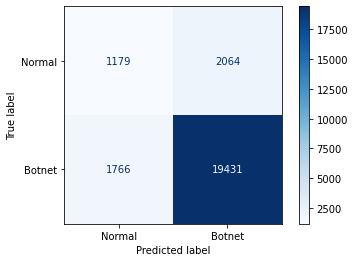

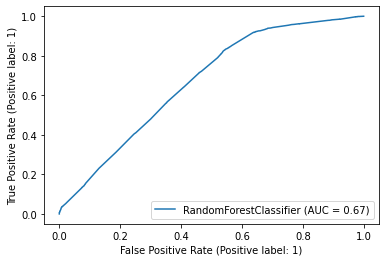

In [10]:
# Evaluate random forest classifier
class_names = ['Normal', 'Botnet']
plot_confusion_matrix(clf, X_test, y_test, cmap = plt.cm.Blues, display_labels=class_names)
plot_roc_curve(clf, X_test, y_test)

In [13]:
# Train support vector machine
from sklearn.linear_model import SGDClassifier
clf = SGDClassifier()

clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

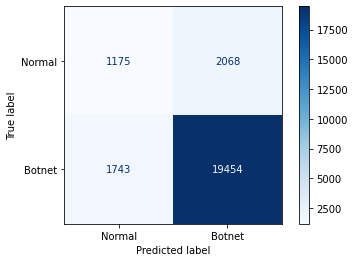

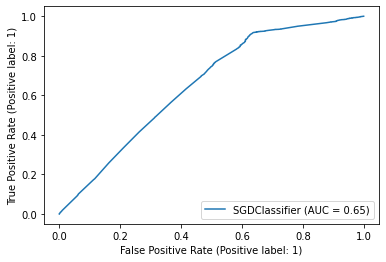

In [14]:
# Evaluate support vector machine
class_names = ['Normal', 'Botnet']
plot_confusion_matrix(clf, X_test, y_test, cmap = plt.cm.Blues, display_labels=class_names)
plot_roc_curve(clf, X_test, y_test)

## Discussion

It seems quite hard to classify botnets on the raw features without the chronological information present, this makes sense when you think about the importance of the temporal dimension in the data